# <center><span style="font-size: 50px; color: blue;">EXPLORATION LIVRABLE 1</span></center>

<center><span style="font-size: 20px; color: purple;">Correlation between the potential temperature $\Theta$ and the geopotential $\Phi$</span></center>
<p></p>

In [2]:
import numpy as np
from sklearn import linear_model
import seaborn as sns
import pandas as pd
import netCDF4 as nc
import matplotlib.pyplot as plt

## <center>Part 1 - import the data

In [3]:
fn = 'Donnees/Donnees_PIE_Meteo.nc'
ds = nc.Dataset(fn)

In [4]:
print(ds)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    creation_date: mer. sept. 21 15:34:43 CEST 2016
    NCL_Version: 6.3.0
    system: Linux lxgmap17 3.14.43-server-1.mga4 #1 SMP Thu May 21 21:43:19 UTC 2015 x86_64 x86_64 x86_64 GNU/Linux
    Conventions: None
    grib_source: PA_THETA_Z_2PVU_2016010100-2016013100.grib
    title: NCL: convert-GRIB-to-netCDF
    dimensions(sizes): initial_time0_hours(31), g0_lat_1(361), g0_lon_2(720), ncl_strlen_0(18)
    variables(dimensions): float32 GP_GDS0_PVL(initial_time0_hours, g0_lat_1, g0_lon_2), float32 POT_GDS0_PVL(initial_time0_hours, g0_lat_1, g0_lon_2), float64 initial_time0_hours(initial_time0_hours), float64 initial_time0_encoded(initial_time0_hours), float32 g0_lat_1(g0_lat_1), float32 g0_lon_2(g0_lon_2), |S1 initial_time0(initial_time0_hours, ncl_strlen_0)
    groups: 


In [5]:
for dim in ds.dimensions.values():
    print(dim)

<class 'netCDF4._netCDF4.Dimension'>: name = 'initial_time0_hours', size = 31
<class 'netCDF4._netCDF4.Dimension'>: name = 'g0_lat_1', size = 361
<class 'netCDF4._netCDF4.Dimension'>: name = 'g0_lon_2', size = 720
<class 'netCDF4._netCDF4.Dimension'>: name = 'ncl_strlen_0', size = 18


We extract the potential temperature $\Theta$ and the geopotential height $h$ fields into the arrays *temp_pot* and *geop_hgt*:
- First dimension is dedicated to the time axis
- Second to latitudes 
- Third to longitudes

In [6]:
temp_pot = np.copy(ds['POT_GDS0_PVL'])
geop_hgt = np.copy(ds['GP_GDS0_PVL'])

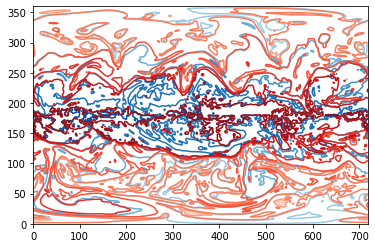

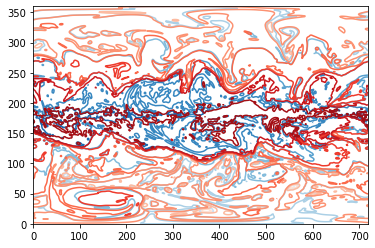

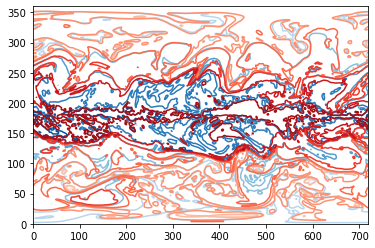

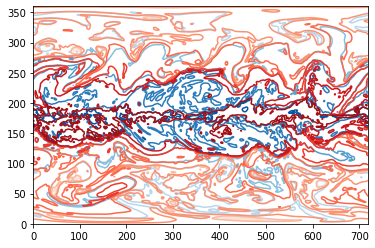

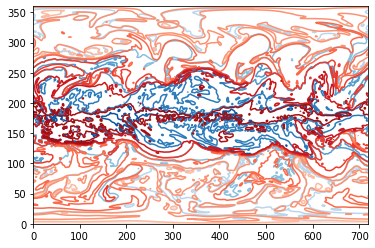

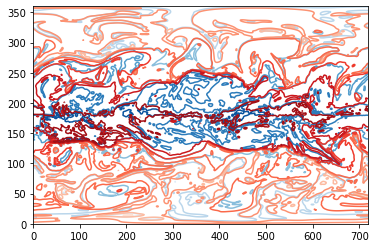

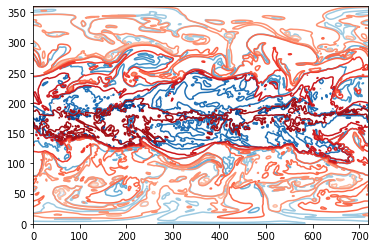

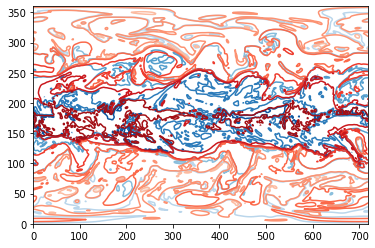

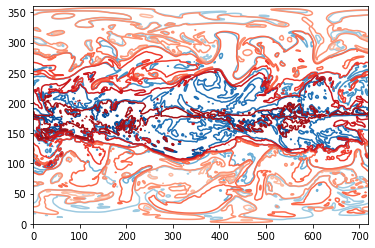

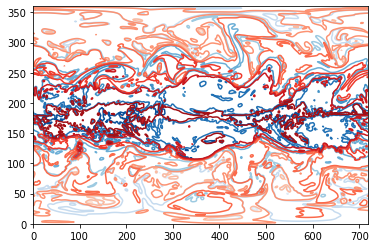

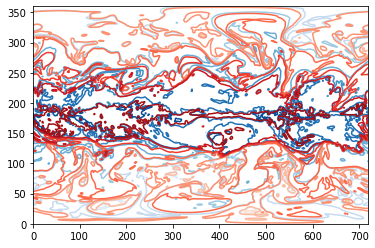

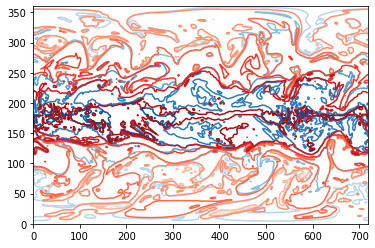

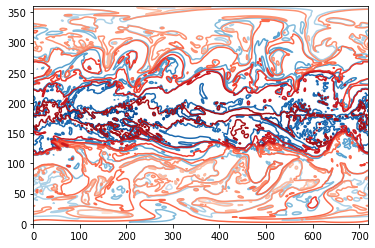

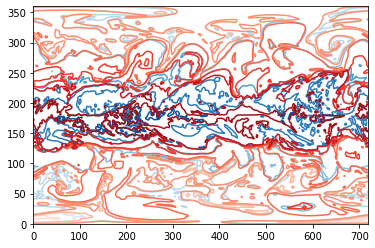

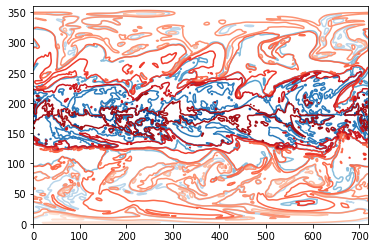

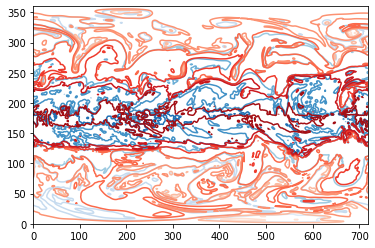

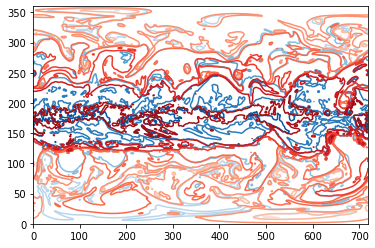

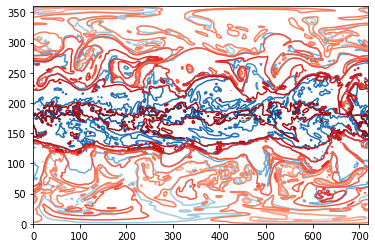

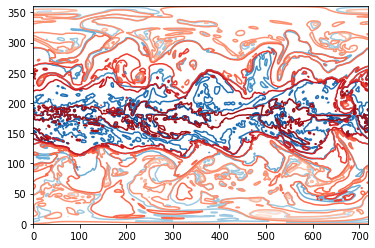

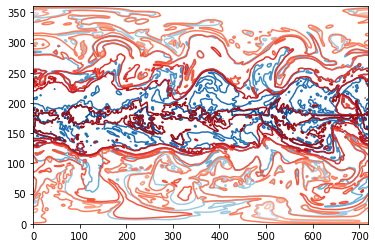

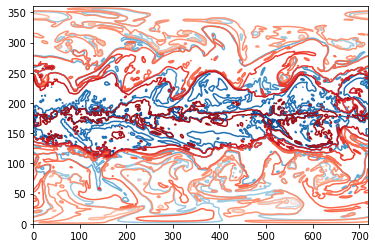

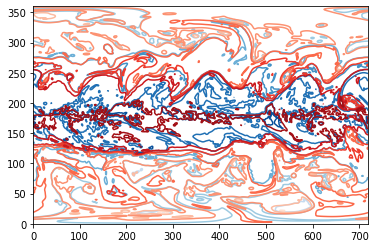

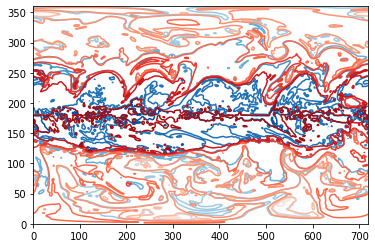

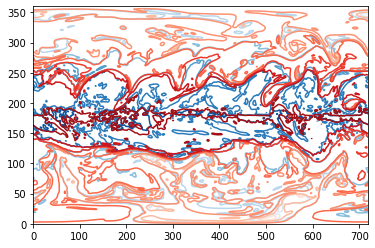

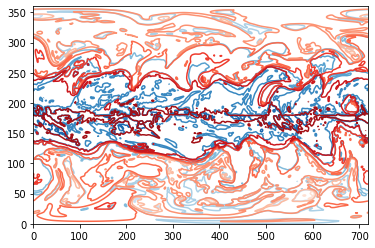

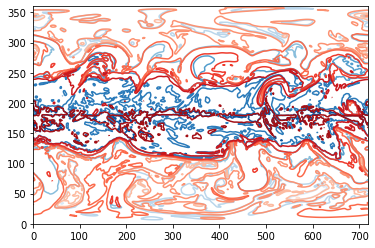

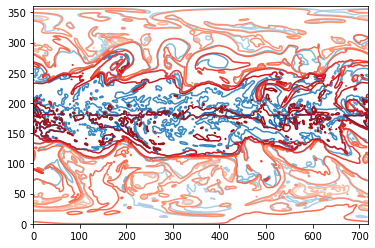

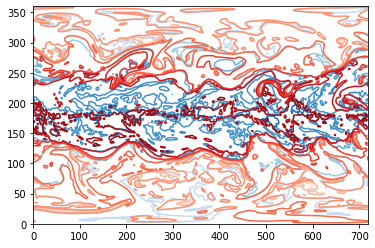

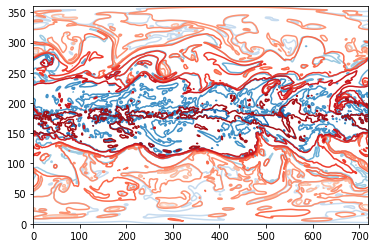

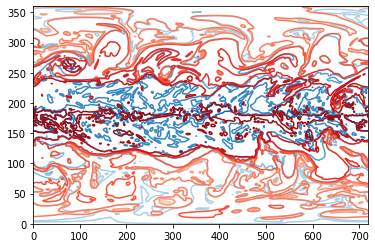

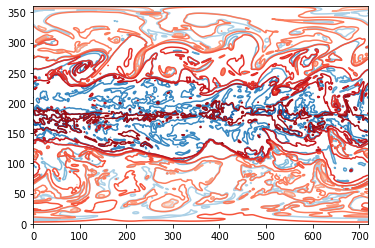

In [7]:
for tmp, geo in zip(temp_pot, geop_hgt):
    plt.figure()
    plt.contour(tmp, cmap='Blues')
    plt.contour(geo, cmap='Reds')
    plt.show()

## <center>Part 2 - pointwise regression

To perform a correlation between $\Theta$ and $\Phi$ we have to extract 2 samples were these 2 quantities are jointly measured. A first way to do this is just to set a fixed point $(\phi,\lambda)$ and analyze the 2 time series $\{\Theta(\phi,\lambda,t)\}_t$ and $\{\Phi(\phi,\lambda,t)\}_t$.
- The function *get_series* computes this 2 series for a given point $(i,j)$.
- We can the perform a linear regression and plot the results with *plot_regression*.

In [8]:
def get_series(i, j):
    return temp_pot[::,i,j], geop_hgt[::,i,j]

def plot_regression(x, y):
    data = pd.DataFrame()
    data['temp_pot'] = x
    data['geop_hgt'] = y
    sns.lmplot(x="temp_pot", y="geop_hgt", data=data)
    regression = linear_model.LinearRegression().fit(x.reshape(-1,1), y.reshape(-1,1))
    plt.figtext(x=0.3, y=0.8, s=r'$R^2={:f}$'.format(regression.score(x.reshape(-1,1), y.reshape(-1,1))))

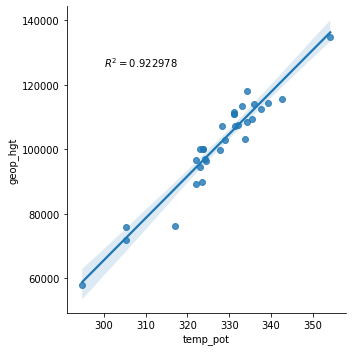

In [9]:
plot_regression(*get_series(280, 500))

As we can see, the correlation $R^2$ is extremely good.  
Let us now investigate all the regions of the map:

In [10]:
n_lat, n_long = temp_pot.shape[1], temp_pot.shape[2]

try:
    r2s = pd.read_csv('Results/pointwise_regression/r2s.csv').to_numpy()
    coefs = pd.read_csv('Results/pointwise_regression/coefs.csv').to_numpy()
    intercepts = pd.read_csv('Results/pointwise_regression/intercepts.csv').to_numpy()
    print('Using saved results')
except:
    print('Computing and saving results')
    coefs = np.zeros((n_lat, n_long))
    intercepts = np.zeros((n_lat, n_long))
    r2s = np.zeros((n_lat, n_long))

    for i in range(n_lat):
        print(i)
        for j in range(n_long):
            x, y = get_series(i, j)
            regression = linear_model.LinearRegression().fit(x.reshape(-1,1), y.reshape(-1,1))
            coefs[i,j] = regression.coef_
            intercepts[i,j] = regression.intercept_
            r2s[i,j] = regression.score(x.reshape(-1,1), y.reshape(-1,1))

    r2s_df = pd.DataFrame(data=r2s.astype(float))
    r2s_df.to_csv('Results/pointwise_regression/r2s.csv', float_format='%.6f', index=False)
    coefs_df = pd.DataFrame(data=coefs.astype(float))
    coefs_df.to_csv('Results/pointwise_regression/coefs.csv', float_format='%.6f', index=False)
    intercepts_df = pd.DataFrame(data=intercepts.astype(float))
    intercepts_df.to_csv('Results/pointwise_regression/intercepts.csv', float_format='%.6f', index=False)

Using saved results


Let us plot the results

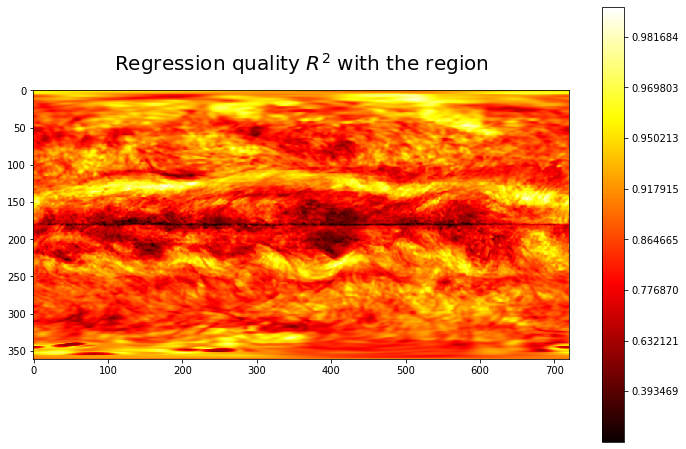

In [11]:
stretch = lambda x: -np.log(1-x)
stretch_inv = lambda y: 1-np.exp(-y)

fig = plt.figure(figsize=(12,8))
img = plt.imshow(stretch(r2s), cmap='hot')
cbar = plt.colorbar(cmap=img)
ticks = cbar.get_ticks()
cbar.set_ticks(ticks)
cbar.set_ticklabels(list(map(lambda y: '{:f}'.format(stretch_inv(y)), ticks)))
plt.title(r'Regression quality $R^2$ with the region', fontsize=20, pad=20)
plt.show()

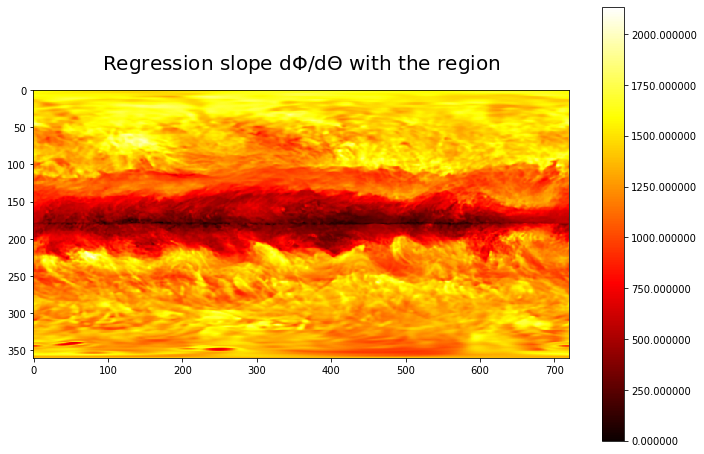

In [12]:
stretch = lambda x: x
stretch_inv = lambda y: y

fig = plt.figure(figsize=(12,8))
img = plt.imshow(stretch(coefs), cmap='hot')
cbar = plt.colorbar(cmap=img)
ticks = cbar.get_ticks()
cbar.set_ticks(ticks)
cbar.set_ticklabels(list(map(lambda y: '{:f}'.format(stretch_inv(y)), ticks)))
plt.title(r'Regression slope $\mathrm{d}\Phi/\mathrm{d}\Theta$ with the region', fontsize=20, pad=20)
plt.show()

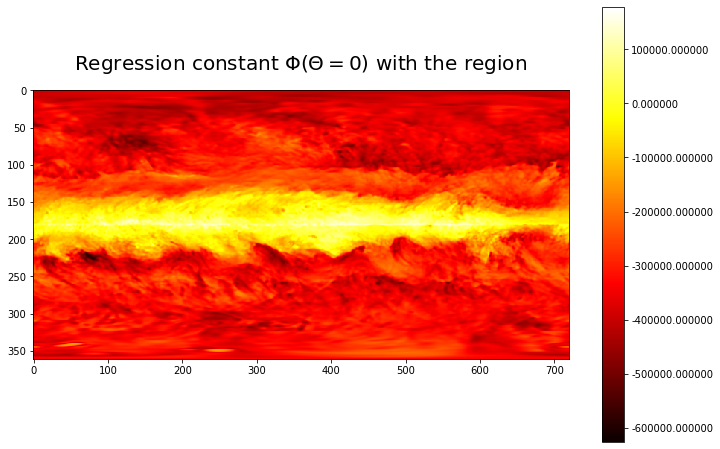

In [13]:
stretch = lambda x: x
stretch_inv = lambda y: y

fig = plt.figure(figsize=(12,8))
img = plt.imshow(stretch(intercepts), cmap='hot')
cbar = plt.colorbar(cmap=img)
ticks = cbar.get_ticks()
cbar.set_ticks(ticks)
cbar.set_ticklabels(list(map(lambda y: '{:f}'.format(stretch_inv(y)), ticks)))
plt.title(r'Regression constant $\Phi(\Theta=0)$ with the region', fontsize=20, pad=20)
plt.show()

## <center>Part 3 - timewise and full regression

In [14]:
regression = linear_model.LinearRegression().fit(temp_pot[:,:,:].reshape(-1,1), geop_hgt[:,:,:].reshape(-1,1))

In [15]:
regression.score(temp_pot[:,:,:].reshape(-1,1), geop_hgt[:,:,:].reshape(-1,1))

0.9562632461137772

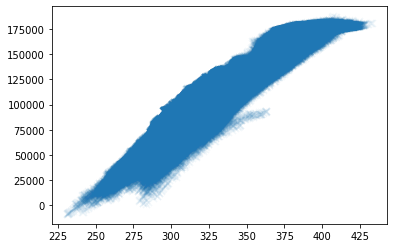

In [21]:
plt.scatter(temp_pot[:,:,:].reshape(-1,1), geop_hgt[:,:,:].reshape(-1,1), s=50, marker='x', alpha=0.05)

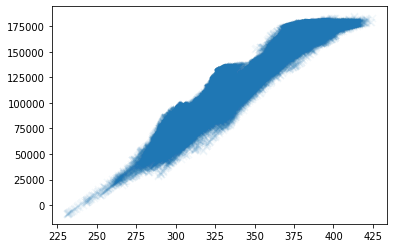

In [20]:
plt.scatter(temp_pot[0,:,:].reshape(-1,1), geop_hgt[0,:,:].reshape(-1,1), s=50, marker='x', alpha=0.05)

In [22]:
def get_series_iso_lat(i):
    return temp_pot[::,i,::].reshape(-1), geop_hgt[::,i,::].reshape(-1)

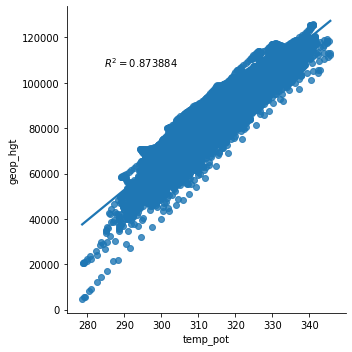

In [23]:
plot_regression(*get_series_iso_lat(300))

In [24]:
n_lat, n_long = temp_pot.shape[1], temp_pot.shape[2]

try:
    r2s_lat = pd.read_csv('Results/latwise_regression/r2s.csv').to_numpy()
    coefs_lat = pd.read_csv('Results/latwise_regression/coefs.csv').to_numpy()
    intercepts_lat = pd.read_csv('Results/latwise_regression/intercepts.csv').to_numpy()
    print('Using saved results')
except:
    print('Computing and saving results')
    coefs_lat = np.zeros(n_lat)
    intercepts_lat = np.zeros(n_lat)
    r2s_lat = np.zeros(n_lat)

    for i in range(n_lat):
        print(i)
        x, y = get_series_iso_lat(i)
        regression = linear_model.LinearRegression().fit(x.reshape(-1,1), y.reshape(-1,1))
        coefs_lat[i] = regression.coef_
        intercepts_lat[i] = regression.intercept_
        r2s_lat[i] = regression.score(x.reshape(-1,1), y.reshape(-1,1))

    r2s_lat_df = pd.DataFrame(data=r2s_lat.astype(float))
    r2s_lat_df.to_csv('Results/latwise_regression/r2s.csv', float_format='%.6f', index=False)
    coefs_lat_df = pd.DataFrame(data=coefs_lat.astype(float))
    coefs_lat_df.to_csv('Results/latwise_regression/coefs.csv', float_format='%.6f', index=False)
    intercepts_lat_df = pd.DataFrame(data=intercepts_lat.astype(float))
    intercepts_lat_df.to_csv('Results/latwise_regression/intercepts.csv', float_format='%.6f', index=False)

Using saved results


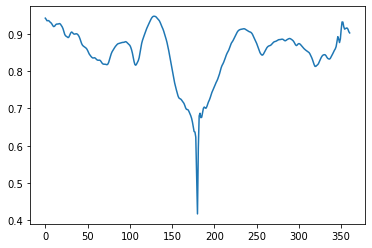

In [25]:
plt.plot(r2s_lat)

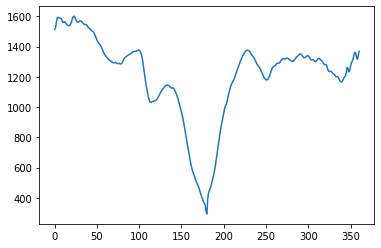

In [211]:
plt.plot(coefs_lat)

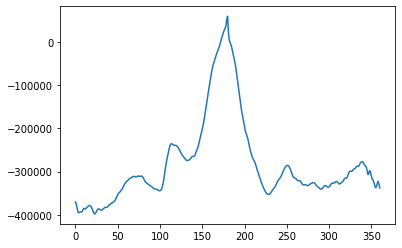

In [56]:
plt.plot(intercepts_lat)

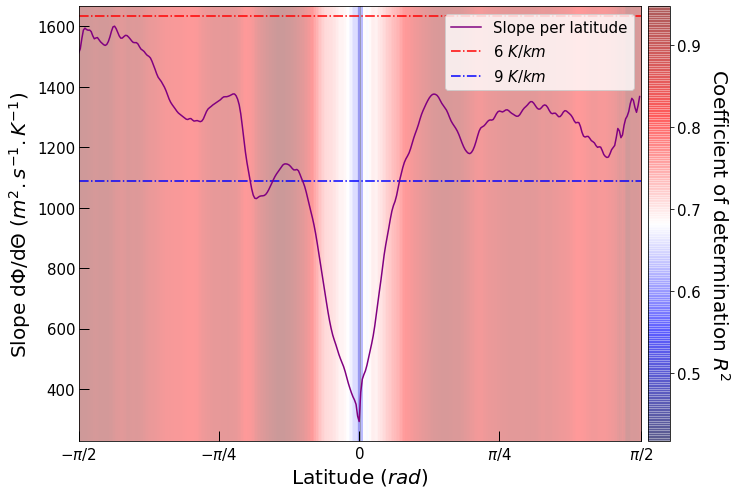

In [212]:
g = 9.81 # avg gravitational acceleration field m.s^-2

fig = plt.figure(figsize=(12,8))
ax = plt.subplot(111)
ax.plot(coefs_lat, color='purple', label='Slope per latitude')
img = ax.imshow(r2s_lat.T, alpha=0.4, extent=[0,361,*ax.get_ylim()], aspect='auto', cmap='seismic')
cbar = plt.colorbar(img, pad=0.01)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(label=r'Coefficient of determination $R^2$', fontsize=20, rotation=-90, labelpad=30)
#plt.hlines(y=np.average(coefs_lat*r2s_lat)/np.average(r2s_lat), xmin=0, xmax=361, label=r'AVG slope with $R^2$')
plt.hlines(y=g*1e3/6, xmin=0, xmax=361, label=r'$6$ $K/km$', linestyle='-.', color='red')
plt.hlines(y=g*1e3/9, xmin=0, xmax=361, label=r'$9$ $K/km$', linestyle='-.', color='blue')
plt.legend(fontsize=15)
ax.set_xticks([0,90, 180, 270, 361]) 
ax.set_xticklabels([r'$-\pi/2$',r'$-\pi/4$', r'$0$', r'$\pi/4$', r'$\pi/2$']) 
ax.tick_params(labelsize=15, direction='in', length=10, width=1)
plt.xlabel(r'Latitude $(rad)$', fontsize=20)
plt.ylabel(r'Slope $\mathrm{d}\Phi/\mathrm{d}\Theta$ $(m^2.s^{-1}.K^{-1})$', fontsize=20)
plt.show()

# <center>Part 4 - complex regression